In [1]:
from analysis import * 

In [2]:
import multiprocessing
# Count available cores
cores = multiprocessing.cpu_count()
# In this case the amount of executors will be equal to the amount of cores
instances = cores

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.driver.memory", "3g") \
          .config("spark.executor.memory", "4g") \
          .config("spark.executor.instances", cores) \
          .config("spark.executor.cores", cores//instances) \
          .config("spark.sql.shuffle.partitions", cores) \
          .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
          .config("spark.sql.execution.arrow.enabled", "true") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

dataframe = spark.read.csv('src/datasets/HI-Small_Trans.csv', header=False, schema=get_schema())\
    .filter('timestamp!="Timestamp"')

#small_sampled_df = small_df.sample(fraction=0.1, seed=42)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/27 13:56:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataframe.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- from_bank: integer (nullable = true)
 |-- from_account: string (nullable = true)
 |-- to_bank: integer (nullable = true)
 |-- to_account: string (nullable = true)
 |-- amount_received: double (nullable = true)
 |-- receiving_currency: string (nullable = true)
 |-- amount_paid: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- payment_format: string (nullable = true)
 |-- is_laundering: integer (nullable = true)



# Data cleaning
Data cleaning involves the essential task of removing undesirable variables, values, and irregularities from a dataset. These anomalies have the potential to significantly skew the data and consequently impact the results negatively. To achieve a more accurate and reliable analysis, the following steps can be taken for data cleaning:
- Removing missing values
- Identifying and handling duplicated entries

In [4]:
dataframe = clean(dataframe)

Datafram size: 5078345

Finding null values... and transactions removal


Number of removed transactions with null values: 0

Finding duplicated transactions... and transaction removal


Number of removed of duplicated transactions: 9

New dataframe size: 5078336


The operation in addition to cleaning the dataset, also converts the timestamp column into the correct format for analysis purposes

# Analysis
What is the distribution in the dataset? 

In [5]:
dataset_count = dataframe.groupBy('is_laundering').count()
dataset_count.show()
dataset_count = dataset_count.toPandas()

count_laundering = dataset_count.loc[dataset_count['is_laundering'] == 1, 'count'].iloc[0]
count_non_laundering = dataset_count.loc[dataset_count['is_laundering'] == 0, 'count'].iloc[0]

,is_laundering,count
0,1,5177
1,0,5073159


In [6]:
laundering = dataframe.filter('is_laundering==1')
non_laundering = dataframe.filter('is_laundering==0')

The graphs below show the amounts of money received (in blue) and paid (in red) grouped by day, week and month.

### Trend of the sums of money

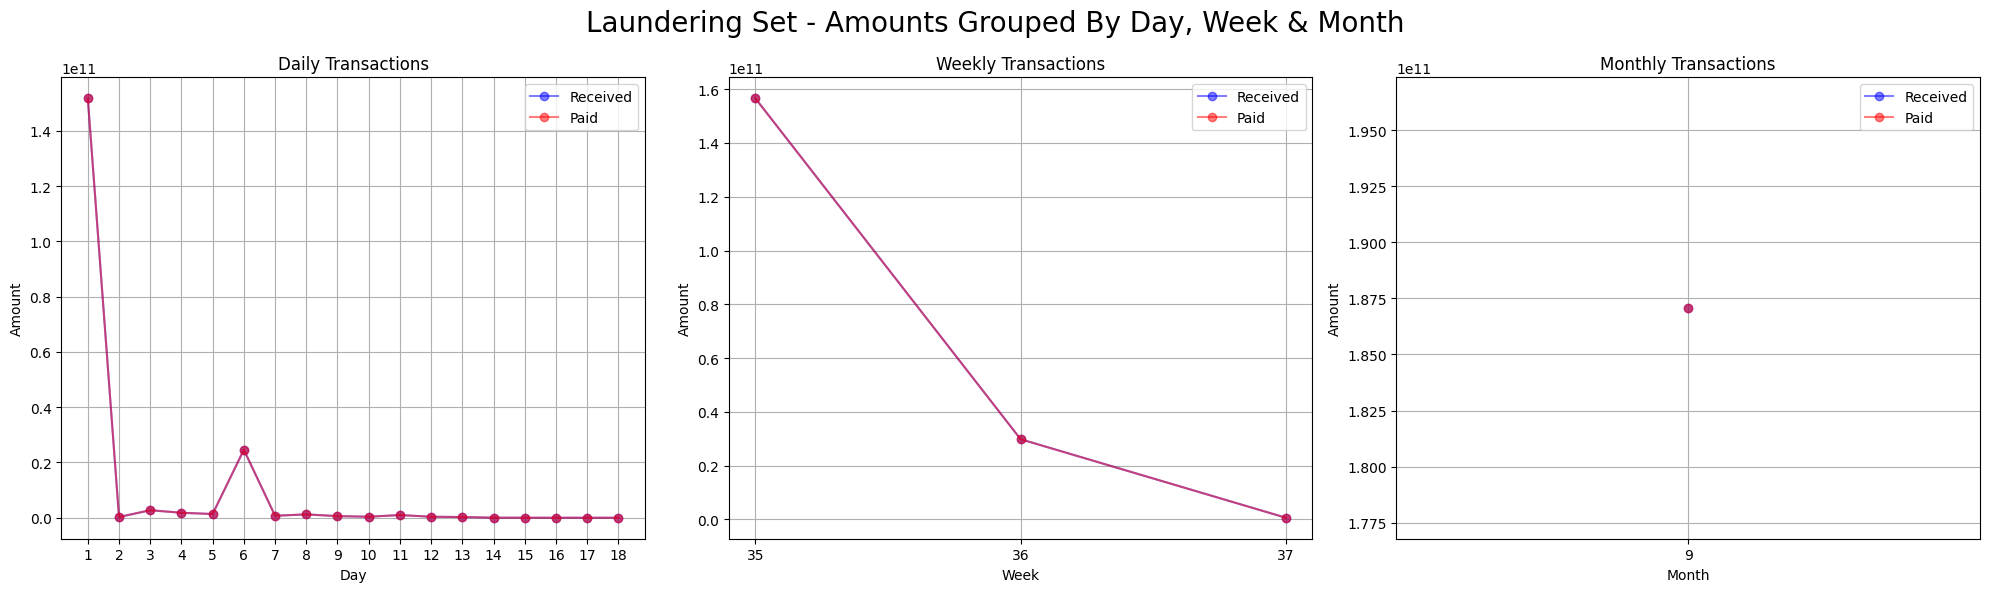

In [7]:
trend_amounts(laundering, 'Laundering Set')
trend_amounts(non_laundering, 'Non Laundering')

As can be easily seen from the graphs of the laundering operations, it seems that the amounts received and paid are always the same, while in the non laundering set the amounts are different. 

In [ ]:
amounts = ['amount_received','amount_paid']
print('Description of the amounts of the Money Laundering')
laundering.select(amounts).describe().show()
print('Description of the amounts of the Money Non Laundering')
non_laundering.select(amounts).describe().show()

Description of the amounts of the Money Laundering


+-------+--------------------+--------------------+
|summary|     amount_received|         amount_paid|
+-------+--------------------+--------------------+
|  count|                5177|                5177|
|   mean| 3.613531041281268E7| 3.613531041281268E7|
| stddev|1.5279186697981372E9|1.5279186697981372E9|
|    min|            0.003227|            0.003227|
|    max|   8.485314417958E10|   8.485314417958E10|
+-------+--------------------+--------------------+

Description of the amounts of the Money Non Laundering


+-------+--------------------+-------------------+
|summary|     amount_received|        amount_paid|
+-------+--------------------+-------------------+
|  count|             5073159|            5073159|
|   mean|   5957973.048413505|  4477007.986285347|
| stddev|1.0365643679451792E9|8.688470674682603E8|
|    min|              1.0E-6|             1.0E-6|
|    max| 1.04630236329348E12|1.04630236329348E12|
+-------+--------------------+-------------------+



In [ ]:
laundering_same_amount = laundering.filter(col('amount_received') == col('amount_paid')).count()
non_laundering_same_amount = non_laundering.filter(col('amount_received') == col('amount_paid')).count()

print('Percentage of transactions with the same amount')
get_percentage(count_laundering, laundering_same_amount, 'Laundering set')
get_percentage(count_non_laundering, non_laundering_same_amount, 'Non Laundering set')

Percentage of transactions with the same amount
Laundering set :  100.0%
Non Laundering set :  98.57773036484762%


### Transactions Per Day

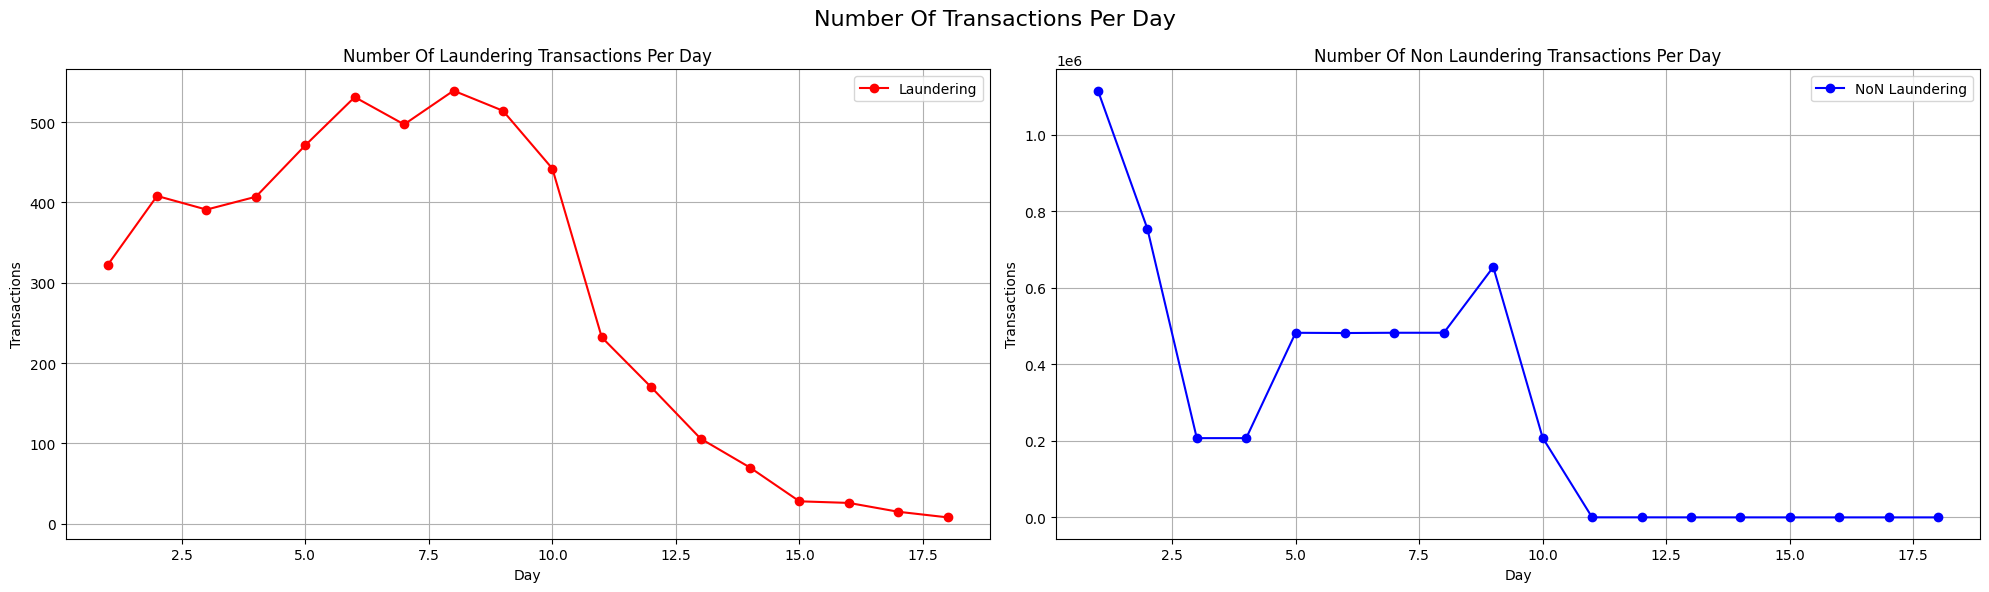

In [ ]:
trend_transactions_x_day(dataframe)

From the graph we can deduce that there is no direct correlation between laundering transactions and days

### Payment Format

In [ ]:
def plot_payment_format(df, df_type):
    plt.figure(figsize=(20, 5))
    payment_format = df.groupBy('payment_format').agg(count('*').alias('count')).toPandas()
    plt.bar(payment_format['payment_format'], payment_format['count'])
    plt.xlabel('Payment format')
    plt.ylabel('Number of transactions')
    plt.title('{} - Types of payment format'.format(df_type), fontsize=16)
    plt.show()

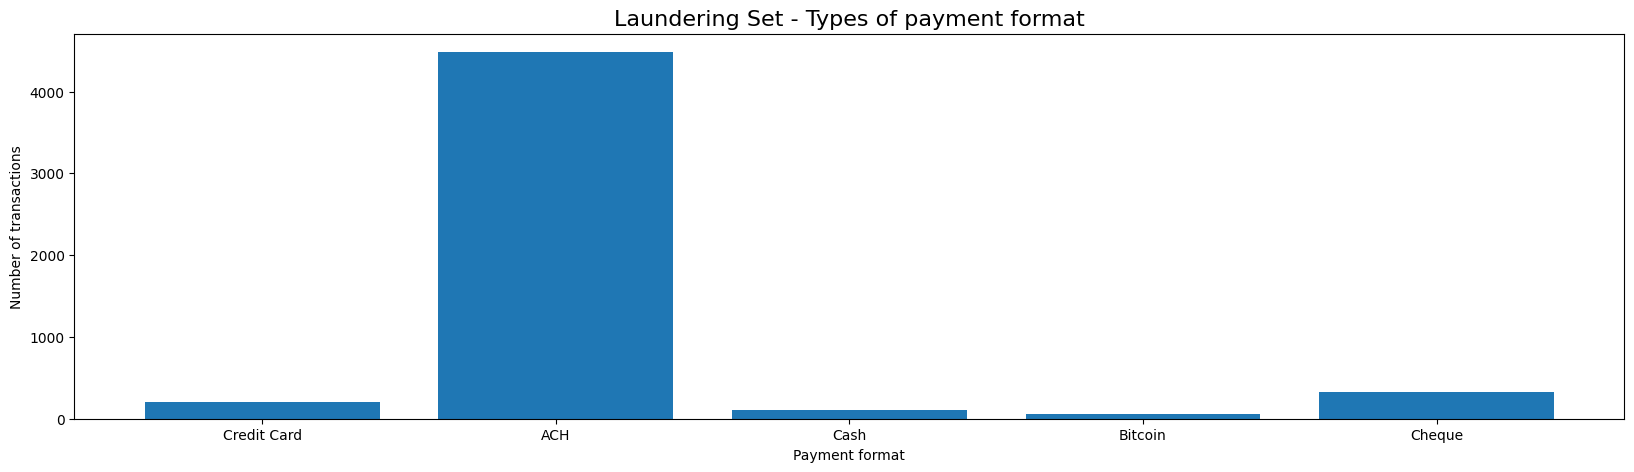

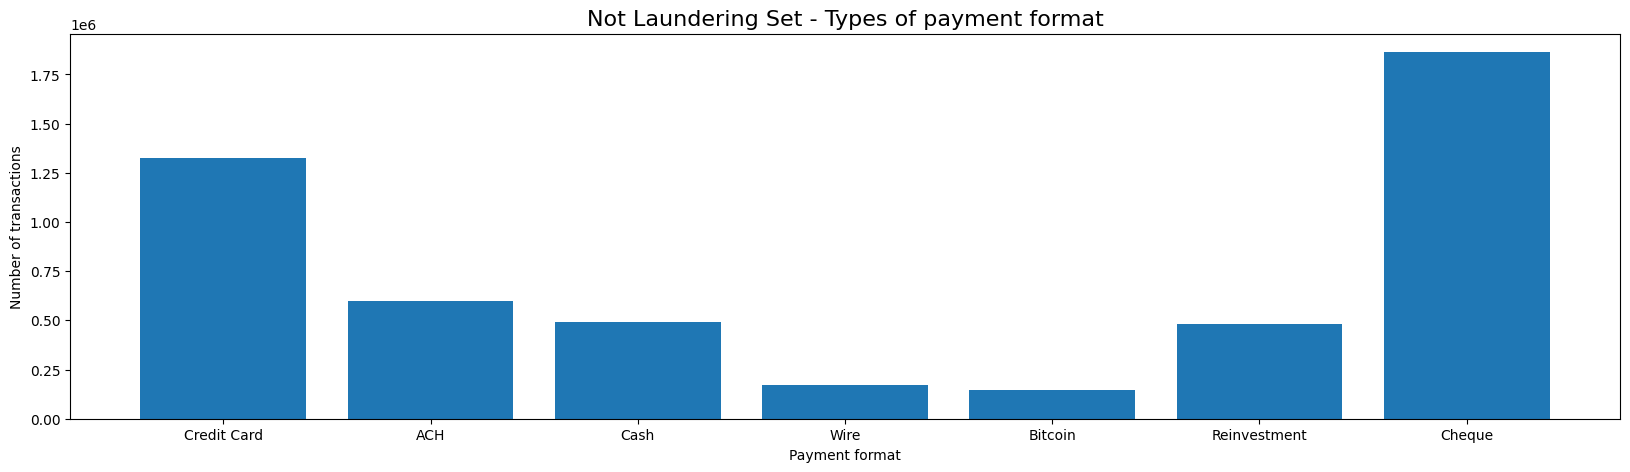

In [ ]:
plot_payment_format(laundering, 'Laundering Set')
plot_payment_format(non_laundering, 'Non Laundering Set')

The number of money laundering transactions whose payment format is ACH clearly prevalent over all other types.

### Receiving and Payment Currency

In [ ]:
def n_currencies(df, df_type):
    currency_t = df.groupBy('receiving_currency').agg(count('*').alias('count')).toPandas()
    currency_f = df.groupBy('payment_currency').agg(count('*').alias('count')).toPandas()

    bar_width = 0.35

    x = range(len(currency_t))

    plt.figure(figsize=(20, 5))

    plt.bar(x, currency_t['count'], width=bar_width, label='Receiving Currency', color='blue')

    plt.bar([i + bar_width for i in x], currency_f['count'], width=bar_width, label='Payment Currency', color='red')

    plt.xlabel('Currency')
    plt.ylabel('Number of transactions')
    plt.title('{} - Types of currencies'.format(df_type), fontsize=16)
    
    plt.xticks([i + bar_width/2 for i in x], [text.replace(" ", "\n") for text in currency_t['receiving_currency']], ha='center')
    
    plt.legend()
    plt.show()

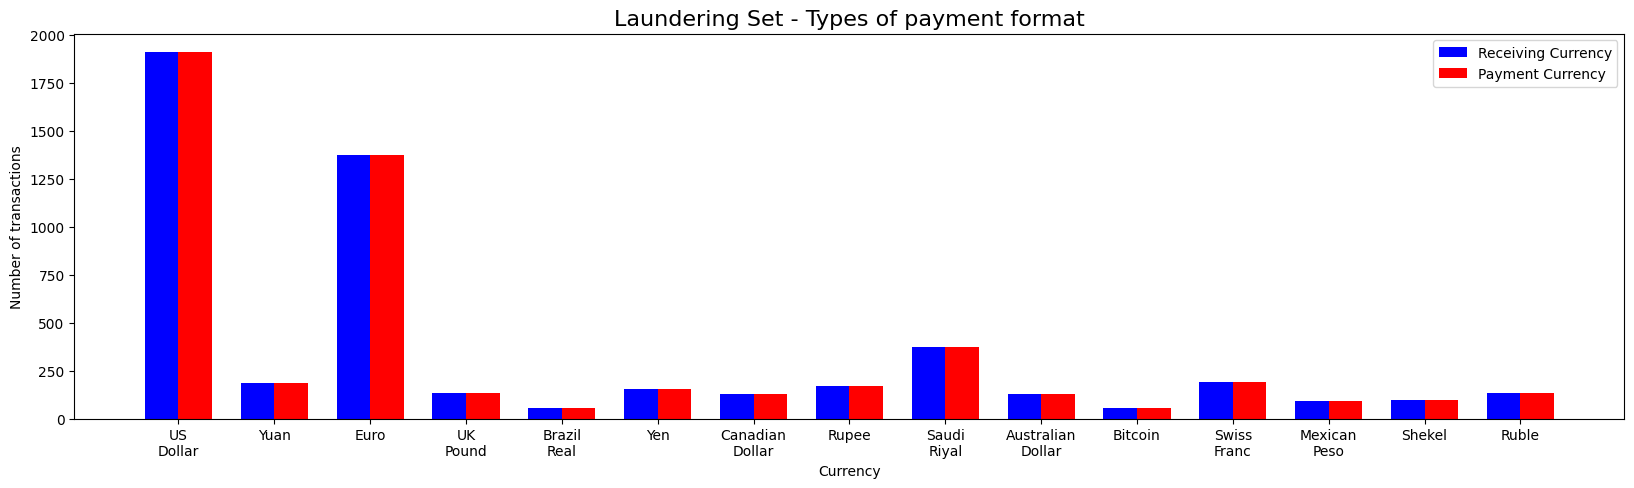

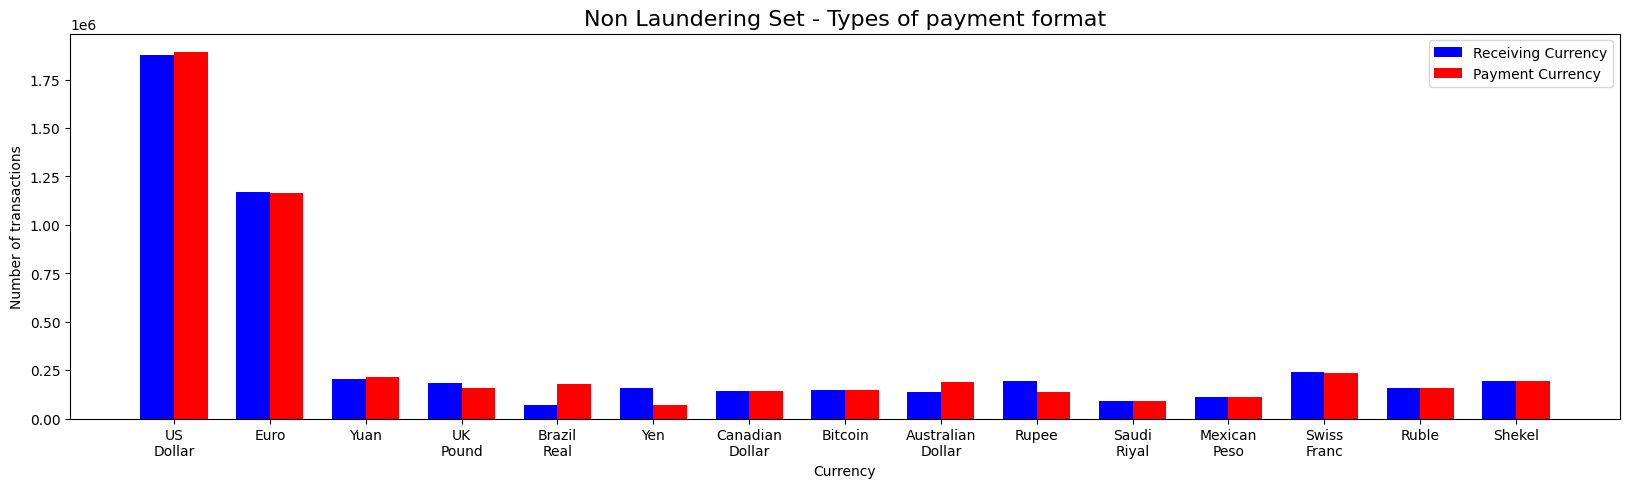

In [ ]:
n_currencies(laundering, 'Laundering Set')
n_currencies(non_laundering, 'Non Laundering Set')

In [ ]:
def plot_amounts(df, df_type):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.set_facecolor('white')
    group_by_type('receiving_currency', df, 'Receiving Currency - Pie Chart', ax1)
    group_by_type('payment_currency', df, 'Payment Currency - Pie Chart', ax2)
    fig.suptitle('{} - Currency Distribution'.format(df_type), fontsize=16)
    plt.tight_layout()
    plt.show()

def group_by_type(col, dataframe, title, ax):
    amount = dataframe.groupBy(col).count().sort(desc('count'))
    
    amount_df = amount.toPandas()
    counts = amount_df['count']
    
    labels = amount_df[col]
    draw_pie(counts, labels, title, ax)


def draw_pie(counts, labels, title, ax):
    wedges, l, _ = ax.pie(counts, labels=labels, autopct='', textprops={'color': 'k'})
    ax.set_title(title)

    percentages = [f'{val/sum(counts)*100:.1f}%' for val in counts]
    
    legend_labels = [f'{labels[i]}: {percentages[i]} ({counts[i]})' for i in range(len(labels))]
    ax.legend(wedges, legend_labels, title='Legend', loc='center left', bbox_to_anchor=(1.15, 0, 0.5, 1))

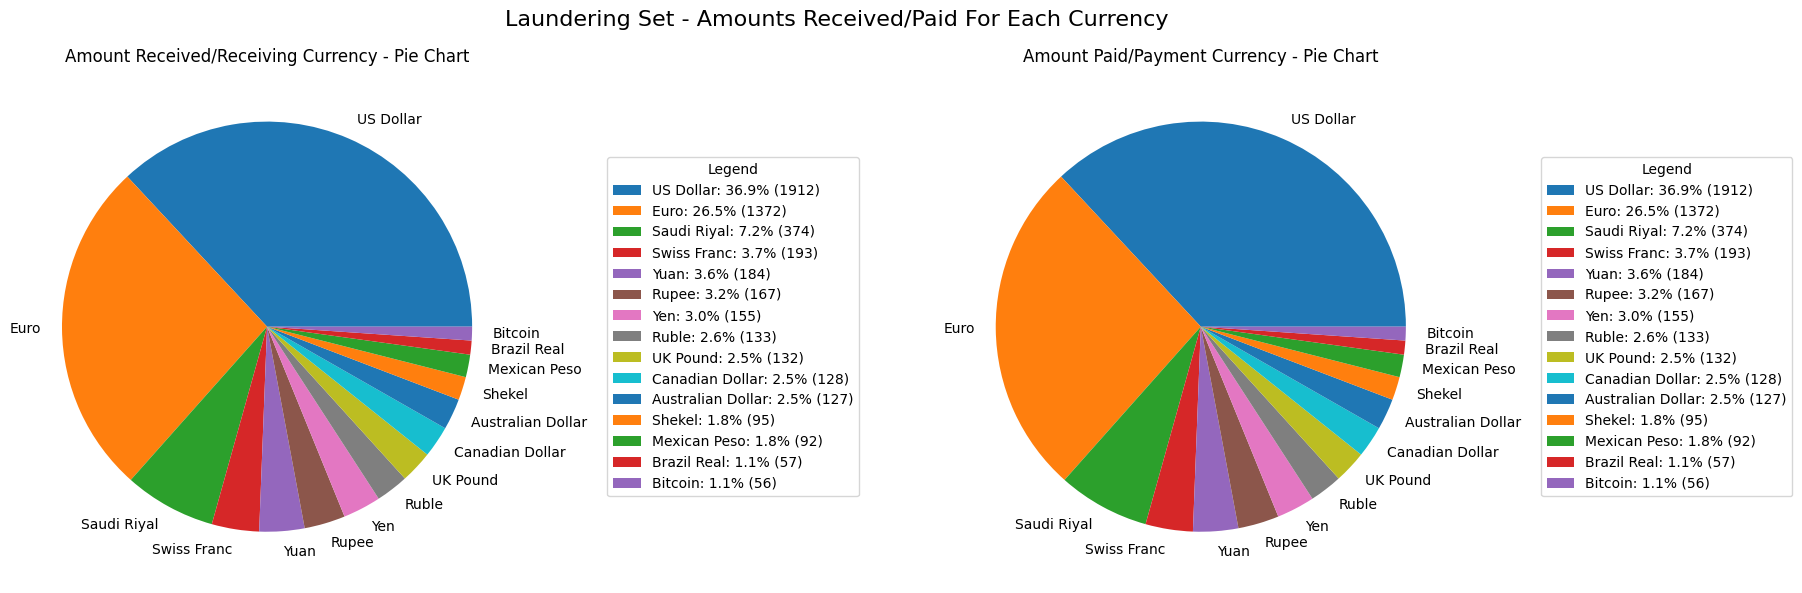

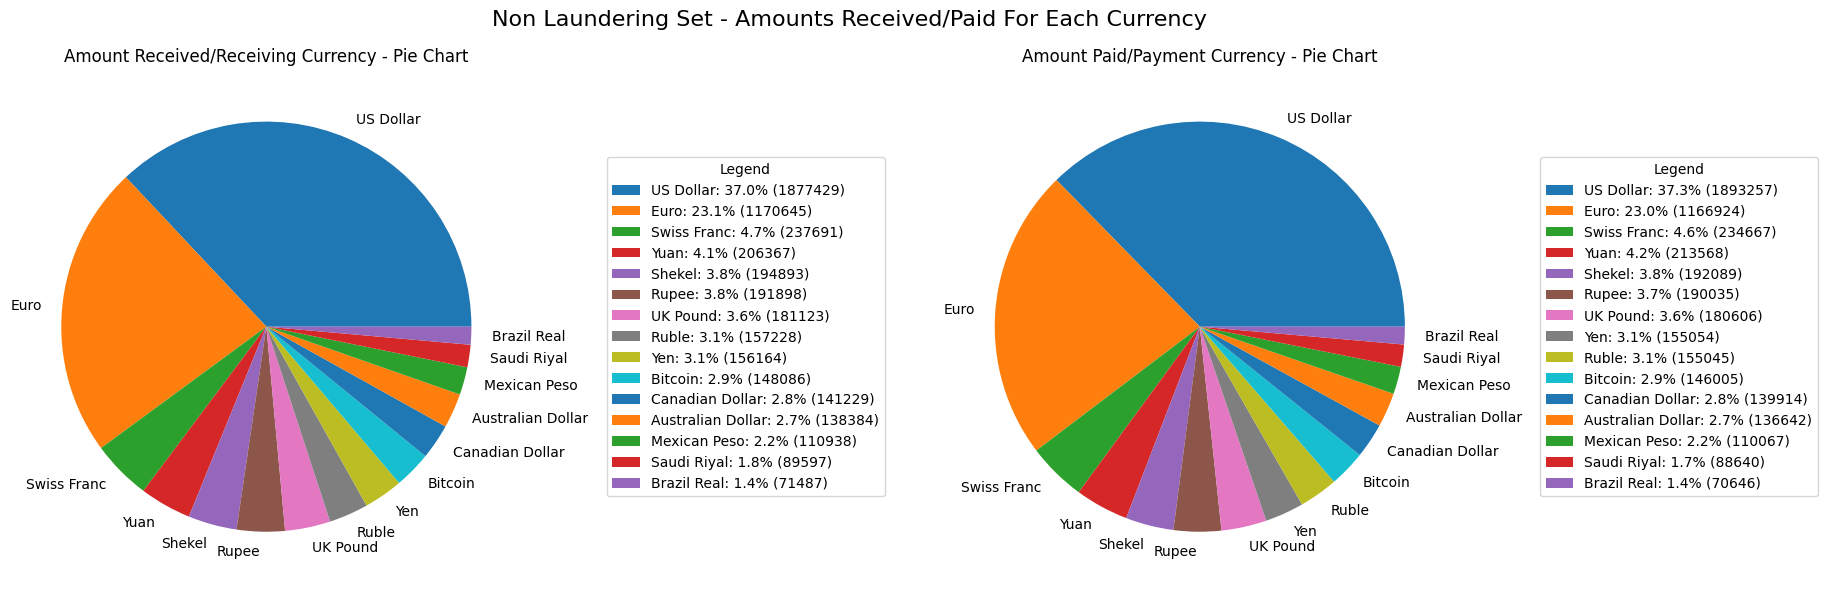

In [ ]:
plot_amounts(laundering, 'Laundering Set')
plot_amounts(non_laundering, 'Non Laundering Set')

## Summary

In [ ]:
def get_summary(col1, col2, percentage):
    filtered_laundering = laundering.filter(col(col1) == col(col2)).count()
    filtered_non_laundering = non_laundering.filter(col(col1) == col(col2)).count()

    print(percentage)    
    
    print('Laundering set: ','{}%'.format(round((filtered_laundering*100/count_laundering),2)))
    print('Non Laundering set: ','{}%'.format(round((filtered_non_laundering*100/count_non_laundering),2)),'\n')


In [ ]:
get_summary('from_account', 'to_account', 'Percentage of self-pay transactions (same account)')
get_summary('from_bank', 'to_bank', 'Percentage of transactions to the same bank')
get_summary('receiving_currency', 'payment_currency', 'Percentage of transactions with the same currency')
get_summary('amount_received', 'amount_paid', 'Percentage of transactions with the same amounts')

Percentage of self-pay transactions (same account)
Laundering set:  0.21%
Non Laundering set:  11.65% 



Percentage of transactions to the same bank
Laundering set:  1.99%
Non Laundering set:  13.62% 



Percentage of transactions with the same currency
Laundering set:  100.0%
Non Laundering set:  98.58% 



Percentage of transactions with the same amounts
Laundering set:  100.0%
Non Laundering set:  98.58% 

